# Assignment 5, Eric Johansson & Max Sonnelid

In this assignment, we will see a few different approaches to building image classifiers using convolutional neural networks. With a small image dataset, our task is to train a CNN that can find images that contain cars. CNNs are data-hungry in general and we won't get a fantastic accuracy using this dataset, so as an alternative we'll explore the opportunity to "piggyback" on a pre-trained CNN model for another image classification task.

The purposes of this assignment is to practice the use of the Keras library for neural network development, get some practical experience of working with image data and CNNs, investigate overfitting in CNNs and learn how to improve your CNN using data augmentation and transfer learning tricks.

## Introduction: Loading images from a directory

In this first introduction step, the raw image data will be loaded to two data generators: one for the training data and one for the validation data. These data generators will then convert the images to numerical Numpy arrays. For demonstration, an image from the dataset will be shown together with its label (1 for car and 0 for no car).

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Defines how the images should be converted into Numpy data.
data_gen = ImageDataGenerator(rescale=1.0/255)

#Create training data (code copied from assignment PM)

imgdir = 'data/a5_images' 
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [81]:
#Create validation data (code copied from assignment PM)

validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 576 images belonging to 2 classes.


In [82]:
#Load one batch from the training generator

Xbatch, Ybatch = train_generator.next()
Xbatch.shape

(32, 64, 64, 3)

1.0


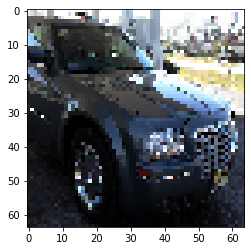

In [83]:
from matplotlib import pyplot as plt

#Show an image from Xtest
plt.imshow(Xbatch[7])

#Print whether it depicts a car (1) or not (0)
print(Ybatch[7])

## Part 1: Training a convolutional neural network

In this part, the image data in the training data generator will be used for training a convolutional neural network and eventually tested on the validation data generator. The below created CNN is based on the network from "CNN digit classification example.ipynb" demonstrated during a lecture and only small modifications for fitting the CNN to this task were made. It was attempted to both add a convolutional layer and remove a convolutional layer. However, this did not change the accuracy and loss values any significantly. It would have been interesting to research more about the properties of different layers in a neural network and in such a way hopefully improve the final accuracy of the network. However, with the original implementation below we still managed to achieve a validation accuracy of 0.750, which is considerably better compared to the 0.500 accuracy expected from a dummy classifier. Therefore, we chose to stay with this implementation. 



In [84]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import backend as K

In [85]:
num_classes = 1

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),activation='relu',input_shape=(train_generator.target_size[0], train_generator.target_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
          epochs=20,
          verbose=1,
          validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - 14s 285ms/step - loss: 0.6517 - accuracy: 0.5962 - val_loss: 0.6419 - val_accuracy: 0.6684
Epoch 2/20
50/50 [==============================] - 15s 303ms/step - loss: 0.5018 - accuracy: 0.7619 - val_loss: 0.5935 - val_accuracy: 0.7031
Epoch 3/20
50/50 [==============================] - 14s 276ms/step - loss: 0.4471 - accuracy: 0.7975 - val_loss: 0.5140 - val_accuracy: 0.7656
Epoch 4/20
50/50 [==============================] - 14s 283ms/step - loss: 0.4325 - accuracy: 0.7975 - val_loss: 0.5040 - val_accuracy: 0.7778
Epoch 5/20
50/50 [==============================] - 15s 302ms/step - loss: 0.3867 - accuracy: 0.8319 - val_loss: 0.5090 - val_accuracy: 0.7795
Epoch 6/20
50/50 [==============================] - 14s 286ms/step - loss: 0.3361 - accuracy: 0.8606 - val_loss: 0.5635 - val_accuracy: 0.7743
Epoch 7/20
50/50 [==============================] - 14s 281ms/step - loss: 0.2815 - accuracy: 0.8844 - val_loss: 0.5797 - val_accuracy: 0.7604

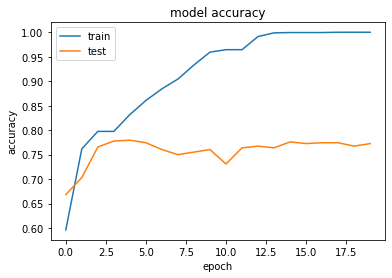

In [86]:
#Plot the training and test accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

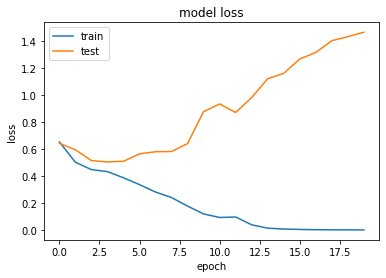

In [87]:
#Plot the training and test loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Studying the curves for the model accuracy as well as the model loss, it is apparent that after only a few number of epochs (2 - 4), both the validation accuracy stops increasing and the validation loss stops decreasing. This implies that after 2 - 4 epochs, the model becomes considerably overfitted and thus learns to recognize specific properties of the training images, which are not generalizable to the validation images. Therefore, in this case, it is recommended that only 2 - 4 epochs should be used for training the model.

## Part 2: Data augmentation

The only real difference from part 1 is the different implementation of the ImageDataGenerator in the beginning, where it is set that the images on random should be horizontally flipped, vertically flipped, rotated in a range of 90 degrees and brightness changed in a range of 0.2 and 0.7. The implementation of the CNN is identical to the implementation in part 1.

In [88]:
#Defines how the images should be converted into Numpy data. Here the images are randomly horizontally flipped, vertically flipped as well as rotated in a range of 90 degrees.

data_gen_aug = ImageDataGenerator(rescale=1.0/255,horizontal_flip=True, vertical_flip=True,rotation_range=90,brightness_range=[0.2,0.7])

#Create training data

imgdir = 'data/a5_images' 
img_size = 64
batch_size = 32

train_generator_aug = data_gen_aug.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [89]:
#Create validation data

validation_generator_aug = data_gen_aug.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 576 images belonging to 2 classes.


In [90]:
# load one batch from training set generator 

Xbatch_aug, Ybatch_aug = train_generator_aug.next()
Xbatch_aug.shape

(32, 64, 64, 3)

1.0


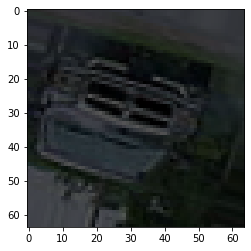

In [91]:
from matplotlib import pyplot as plt

#Show an image from Xbatch_aug
plt.imshow(Xbatch_aug[9])

#Print whether it depicts a car (1) or not (0)
print(Ybatch_aug[9])

In [92]:
# The CNN below is identical with the CNN from part 1

num_classes = 1

model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),activation='relu',input_shape=(train_generator.target_size[0], train_generator.target_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_aug = model.fit(train_generator_aug,
          epochs=20,
          verbose=1,
          validation_data=(validation_generator_aug))

Epoch 1/20
50/50 [==============================] - 26s 512ms/step - loss: 0.6887 - accuracy: 0.5437 - val_loss: 0.6576 - val_accuracy: 0.6372
Epoch 2/20
50/50 [==============================] - 22s 445ms/step - loss: 0.6481 - accuracy: 0.6175 - val_loss: 0.6294 - val_accuracy: 0.6493
Epoch 3/20
50/50 [==============================] - 23s 466ms/step - loss: 0.6242 - accuracy: 0.6500 - val_loss: 0.6470 - val_accuracy: 0.6545
Epoch 4/20
50/50 [==============================] - 25s 495ms/step - loss: 0.6039 - accuracy: 0.6888 - val_loss: 0.6104 - val_accuracy: 0.6927
Epoch 5/20
50/50 [==============================] - 25s 492ms/step - loss: 0.6065 - accuracy: 0.6825 - val_loss: 0.6002 - val_accuracy: 0.6858
Epoch 6/20
50/50 [==============================] - 24s 485ms/step - loss: 0.6076 - accuracy: 0.6744 - val_loss: 0.6531 - val_accuracy: 0.6285
Epoch 7/20
50/50 [==============================] - 23s 465ms/step - loss: 0.5992 - accuracy: 0.6775 - val_loss: 0.5947 - val_accuracy: 0.6927

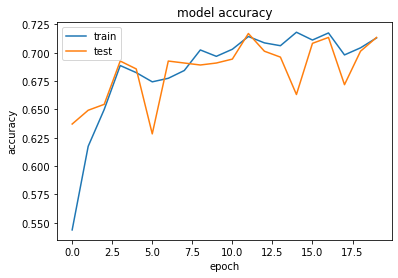

In [93]:
#Plot the training and test accuracy

plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

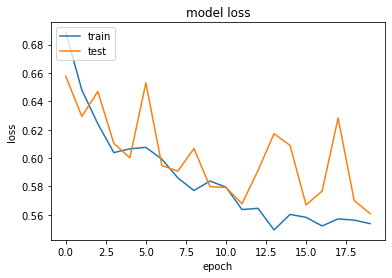

In [94]:
#Plot the training and test loss

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is interesting to study the different behavior of the curves for the model accuracy as well as the model loss compared to part 1. Compared to part 1, there are no signs of overfitting present when the model is trained on 20 epochs as no clear generalization gap between the training and validation accuracy/loss can be noticed. Instead, it is clear that the model has been able to learn more useful general properties about the images for each epoch. However, the accuracy is still worse compared to the accuracy in part 1. Thus, the probable explanation to why no overfitting occurs on the augmented data is that the model through the epochs learns only successively learns to better handle the rather simple twists of the data and does not learn any other useful properties of the data. For this task, it would be interesting to see how much the accuracy and loss can improve with an even higher number of epochs. This was however not done because of the long running time. Furthermore, it would have been interesting to see how the accuracy and loss changes with different kinds of augmentations of the data. However, this was also not done because of the long running time.

## Interlude: Applying a pre-trained convolutional neural network

In this step, we will take advantage of the pre-trained model VGG-16, which has been trained on one of the most famous image databases used in computer vision, called ImageNet. Based on a large number of example images for each class, the VGG-16 model is able to assign class probabilities to an arbitrary image. Firstly, it will be demonstrated how the VGG-16 assigns class probabilities to an image from our dataset.

In [95]:
#Download the VGG-16 model

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

### Demonstration of the VGG-16 model

In [96]:
#Load the image to an Image object

image = load_img('data/a5_images/validation/car/0008.jpg', target_size=(224,224))

#Then convert it to an array
image_array = img_to_array(image)

#Carry out necessary pre-processing
img_arr_processed = preprocess_input(image_array)

#Re-shape the image array into a four-dimensional array
img_4d = img_arr_processed.reshape(1, 224, 224, 3)

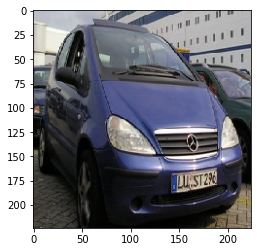

In [97]:
#Show the image

plt.imshow(image)

In [98]:
#Predict the class probabilities for this image

decode_predictions(vggmodel.predict(img_4d))

[[('n03770679', 'minivan', 0.8487036),
  ('n03769881', 'minibus', 0.07553571),
  ('n02814533', 'beach_wagon', 0.018208114),
  ('n03977966', 'police_van', 0.013192148),
  ('n03796401', 'moving_van', 0.010991307)]]

Looking at the class probabilities assigned for the image showed above, they seem rather reasonable as the car shown in the picture very much looks like a minivan, which is predicted with a probability of 85 %.

## Part 3: Using VGG-16 as a feature extractor

In this step, we use the class probabilites assigned by VGG-16 as a feature extractor, where the extracted features are then used as input for two dense layers in a neural network, which can then classify an image as either car or not car. The VGG-16 model will act as a replacement of the convolutional part of the networks created in part 1 and part 2. This solution is an example of transfer learning, which means that we leverage the knowledge stored in a pre-trained model and apply it to our specific task.

Firstly, a method will be created for extracting the features from our dataset (create_vgg16_features()), which will save the features in a binary file (one for the training data and one for the validation data). Secondly, a method will be created for training a neural network on the extracted featues and then make predictions on the validation data set (train_on_cnnfeatures()). Finally, the model accuracy and loss per epoch will be plotted and reflected about in the end.

In [99]:
#Download the VGG-16 model once more with different parameters

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

feature_extractor = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [100]:
#Method for reading and preprocessing a file directory, then extract the features from the VGG-16 model and eventually saves these features into a binary file

def create_vgg16_features(data_type):
    
    #First create a new image data generator
    vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    #Then specify the properties of the image files
    imgdir = 'data/a5_images' 
    img_size = 64
    batch_size = 32

    #Then create a training data generator
    generator_vgg = vgg_data_gen.flow_from_directory(
        imgdir + '/' + data_type,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)
    
    # Apply the VGG-16 model to both the training data and the validation data generator. This will return a four-dimensional NumPy array.
    res = feature_extractor.predict(generator_vgg)

    #Save this NumPy array into a binary file. (Should be done both for the training and validation data)
    with open('data/a5_images/res_' + data_type + '.bin', 'wb') as f:
        np.save(f, res)


In [101]:
# Help method for extracting the labels from the training resp. validation data

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

#Finally, write a method that reads the two files that you created, trains a classifier on the training set, and evaluates on the validation set.

import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import backend as K

def train_on_cnnfeatures(training_file, validation_file):

    #Read the files with the training resp. validation data
    with open(training_file, 'rb') as f: # training_file = 'data/a5_images/res_train.bin'
        training_data = np.load(f)
    
    with open(validation_file, 'rb') as f: # validation_file = 'data/a5_images/res_validation.bin'
        validation_data = np.load(f)

    #Extract the labels for the training resp. validation data
    training_labels = get_labels(training_data.shape[0])
    validation_labels = get_labels(validation_data.shape[0])

    num_classes = 1

    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    history = model.fit(training_data, training_labels,
            epochs=20,
            verbose=1,
            validation_data=(validation_data, validation_labels))
    return history


In [102]:
# Use the two methods create above for first extracting the features from the VGG model and then create a neural network that make predictions on the images

#create_vgg16_features('train')
#create_vgg16_features('validation')
history_vgg = train_on_cnnfeatures('data/a5_images/res_train.bin','data/a5_images/res_validation.bin')

NameError: name 'np' is not defined

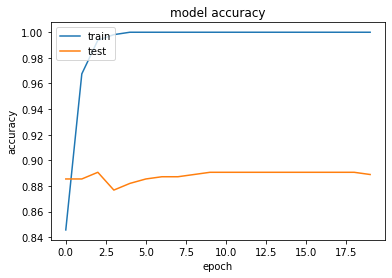

In [152]:
#Plot the training and test accuracy

plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

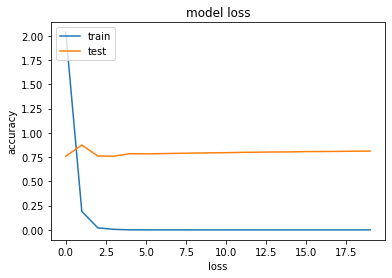

In [153]:
#Plot the training and test loss

plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Both the curves for the model accuracy and the model loss share similarities with the curves from part 1, but here the generalization gap behaves even more extreme. Already after the first epoch the generalization gap is very apparent and thus it is recommended to train the model only on one single epoch. The most probable explanation to this is that the only real learning happens in the VGG-16 model and that the dense layers then very quickly learn to convert the class probabilities into binary classifications. Furthermore, the training time in this part was considerably faster compared to part 1 and part 2, which is explained by the fact that fewer layers are used. It is therefore advantageous to use transfer learning from two perspectives: both from an accuracy perspective and from a speed perspective.

## Part 4: Visualizing the learned features

In this part, we will visualize the patterns extracted by the first convolutional layer in the VGG-16 model by using the weights from that layer. This is done in the kernel_image method, where one can choose whether we want to see the patterns that enables a specfic feature (positive=True) or the patterns that disables a specific feature (positive=False). The first convolutional layer consists of 64 different convolutional filters, which each are multiplied by certain pixel regions in the input image and returns a output (i.e. creates an abstracted picture), and both the positive resp. negative parts of the first six convolutional filters are plotted below. Finally, a feature map is created for a picture in order to visualize in another way how the convolutional layers registers details. This was not required from the assignment, but we thought it was an interesting addition.

In [79]:
#Get the weights in the first convolutional layr in the VGG-16 model

first_layer_weights = feature_extractor.get_weights()[2]
first_layer_weights.shape

(3, 3, 64, 64)

In [72]:
#Utility function for visualizing the patterns extracted by the first convolutional layer.

def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

   # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
         k /= m 

    return k

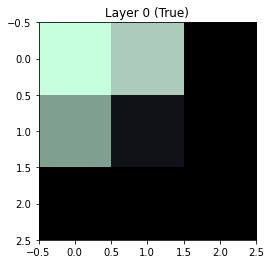

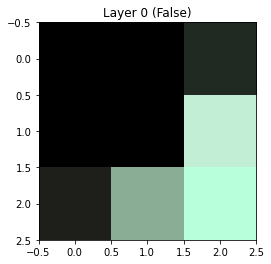

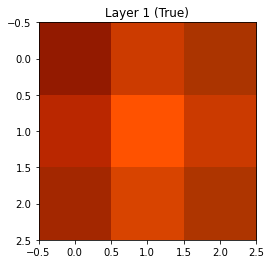

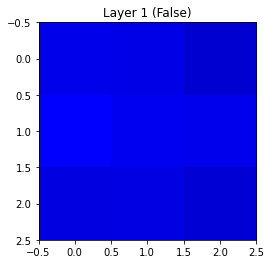

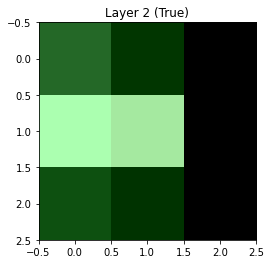

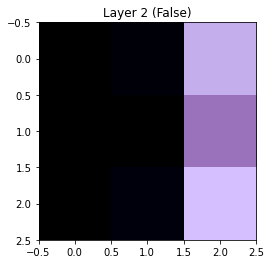

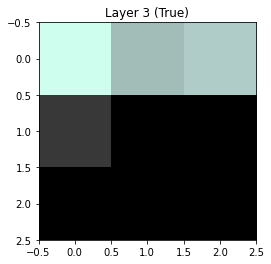

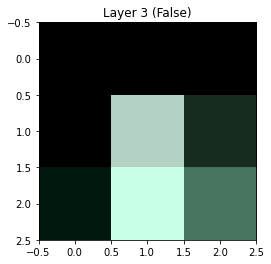

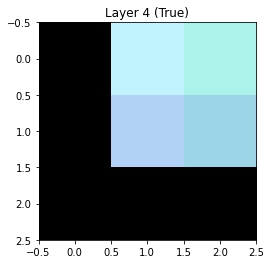

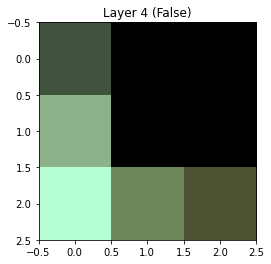

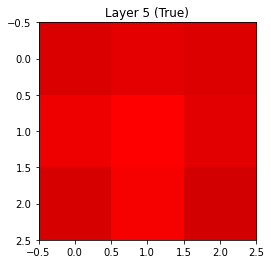

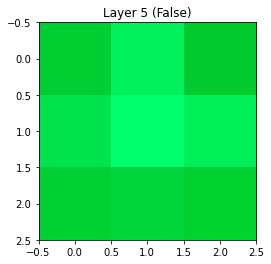

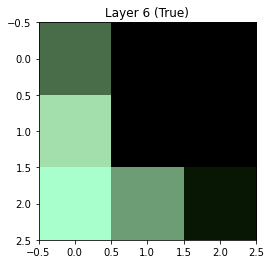

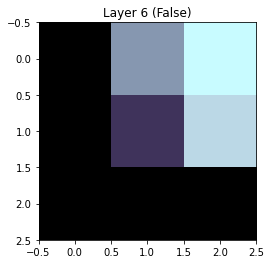

In [73]:
#Below the negative parts of layer 0, 10, 20, 30, 40, 50 resp 60 are shown.
from matplotlib import pyplot as plt

for i in range(7):
    visualization_true = kernel_image(first_layer_weights, i, True)
    plt.figure()
    plt.title('Layer %i (True)' %i)
    plt.imshow(visualization_true)

    visualization_false = kernel_image(first_layer_weights, i, False)
    plt.figure()
    plt.title('Layer %i (False)' %i)
    plt.imshow(visualization_false)

Before drawing any conclusions from the visualized filters above, it can be good to recall the role of a convolutional filter. Somewhat simplified, the convolutional filters are applied to certain parts of the original image and summarizes that part to a single output (weight). When visualizing convolutional filters, darker parts of the filters represent smaller weights while lighter parts of the filters represent larger weights. Studying the visualizations for filter 0, we can clearly see that the filter is looking for details to be present in the upper left part of the filter. If such details are present, the filter is going produce a larger weight and thus increase the probability that a car is predicted. Studying the other filters, it is possible to see that details in other parts of the filters are looked for. For some filters, especially no. 1 and 5, the colour of the detail seems to be the more interesting thing and not whether the detail is present or not.

It was also attempted to visualize some other convolutional layer. However, the code above only returned errors when simply changing the layer number. After some research on the Internet, we then realized that the visualizations of filters in other layers depend on the filters from the preceding layers. For example, if we have two subsequent layers each with 64 filters, each filter in the latter layer has 64 channels to match the input from the former layer. Thus, the number of visualizations in the latter layers has to be multiplied by the number of possible channels. This results in 64 x 64 (4,096) possible visualizations of the filters, which does not really contribute to any additional understanding of the network.

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


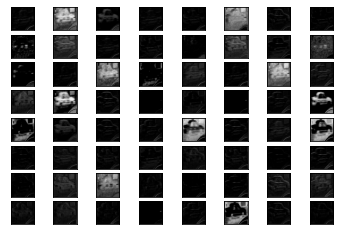

In [76]:
# plot feature map of first conv layer for given image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('data/a5_images/train/car/0007.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
       # figsize = (20,2)
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

A feature map captures the result of applying a certain filter on an input image, which contributes to an understanding of what details the layers detects and preserves. We have taken an example image of a car from our training set and visualized the output from all 64 filters from the first convolutional layer. What could be expected is that feature maps close to the input data detects more fine details, while feature maps close to the output data focuses on the more general features. Looking at the result above, an interesting observation is that some filters show only darkness, while a few filters show images where the car is recognizable. A probable explanation to this phenomenon is that for some filters, no relevant details about a car are registered and thus no information (darkness) is returned to the next layer.

However, the biggest take-away both from the visualization of the convolutional filters and the feature map is that it is a rather hard task for humans to understand how neural networks processes information. Humans make their certain types of abstractions, which are often made in terms of pictures, while neural networks make numerical abstractions. These numerical abstractions are possible to visualize, but it is still important to keep in mind that this is only a visualization. For the neural network, only the numerical features matter. Therefore, these visualizations only give some hints about the details that the neural network look for and should not be overinterpreted. This is also the fascinating thing about neural networks, that they are able to learn things from an image in a way that humans can not learn. If they would learn things in the same way as a human does and thus be more interpretable, they would not be able to exceed the skills of a human, which is often the aim when creating an image recognition system.